*Uploading the data*

In [ ]:
git add your_file.sql
git commit -m "Add SQL file"
git push

In [ ]:
# File location and type
file_location = "/FileStore/tables/iot_devices.json"
file_type = "json"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.show(10)

+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+
|battery_level|c02_level|cca2|cca3|           cn|device_id|         device_name|humidity|             ip|latitude|   lcd|longitude|  scale|temp|    timestamp|
+-------------+---------+----+----+-------------+---------+--------------------+--------+---------------+--------+------+---------+-------+----+-------------+
|            8|      868|  US| USA|United States|        1|meter-gauge-1xbYRYcj|      51|   68.161.225.1|    38.0| green|    -97.0|Celsius|  34|1458444054093|
|            7|     1473|  NO| NOR|       Norway|        2|   sensor-pad-2n2Pea|      70|  213.161.254.1|   62.47|   red|     6.15|Celsius|  11|1458444054119|
|            2|     1556|  IT| ITA|        Italy|        3| device-mac-36TWSKiT|      44|      88.36.5.1|   42.83|   red|    12.83|Celsius|  19|1458444054120|
|            6|     1080|  US| USA|United Stat

In [ ]:
# Create a view or table

temp_table_name = "iot_devices_json"

df.createOrReplaceTempView(temp_table_name)
df.count()

Out[3]: 198164

In [ ]:

permanent_table_name = "iot_devices_json"


In [ ]:
from pyspark.sql.functions import col, asc, count, when

TempFilter1 = df.filter(col("cn") == "Poland").filter(col("device_name").like("sensor-pad%"))
sensor_poland = TempFilter1.count()

print(f"Number of sensor pads from Poland: {sensor_poland}")

df.where((col('cn') == "Poland") & (col('device_name').like("sensor-pad%"))).count()


Number of sensor pads from Poland: 1413
Out[6]: 1413

In [ ]:
df.select("lcd").distinct().show()
distinct_color_count = df.select("lcd").distinct().count()
print(f"Number of distinct LCD colors: {distinct_color_count}")

+------+
|   lcd|
+------+
| green|
|yellow|
|   red|
+------+

Number of distinct LCD colors: 3


In [ ]:
mac_devices_df = df.filter(col("device_name").like("device-mac%"))

# Group by country ("cn") and count the number of MAC devices
country_mac_counts = mac_devices_df.groupBy("cn").agg(count("device_name").alias("mac_device_count"))

# Order by the count in descending order and select the top 5 countries
top_countries = country_mac_counts.orderBy("mac_device_count", ascending=False).limit(5)

# Show the results
top_countries.show()

+-----------------+----------------+
|               cn|mac_device_count|
+-----------------+----------------+
|    United States|           11508|
|            China|            2300|
|            Japan|            2001|
|Republic of Korea|            1999|
|          Germany|            1314|
+-----------------+----------------+



In [ ]:
# Select numerical columns
selected_df = df.select("battery_level", "c02_level", "temp")

# Drop any rows with null values in these columns
selected_df = selected_df.na.drop()

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["battery_level", "c02_level", "temp"], outputCol="features")
assembled_df = assembler.transform(selected_df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


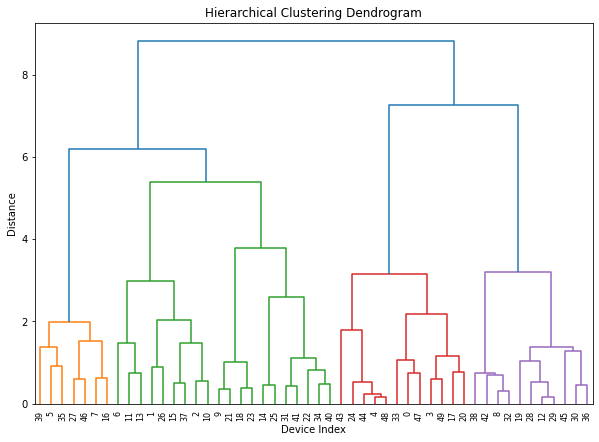

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Take a small sample to make the dendrogram plotting feasible
sample_data = scaled_df.select("scaled_features").limit(50).toPandas()
sample_features = pd.DataFrame(sample_data["scaled_features"].tolist())

# Perform hierarchical clustering using SciPy
Z = linkage(sample_features, method="ward")

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=sample_features.index.tolist())
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Device Index")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Calculate the Pearson correlation between temperature and CO2 level
temperature_c02_corr = df.stat.corr("temp", "c02_level")
print(f"The correlation between temperature and CO2 level is: {temperature_c02_corr}")

The correlation between temperature and CO2 level is: 0.0027097410690436


In [ ]:
# List of column pairs to analyze
columns_to_compare = [("temp", "c02_level"), ("battery_level", "temp"), ("battery_level", "c02_level")]

# Calculate and display correlations for each pair
for col1, col2 in columns_to_compare:
    corr_value = df.stat.corr(col1, col2)
    print(f"The correlation between {col1} and {col2} is: {corr_value}")

The correlation between temp and c02_level is: 0.0027097410690436
The correlation between battery_level and temp is: -0.0028133019164203773
The correlation between battery_level and c02_level is: -0.0005630186116475665


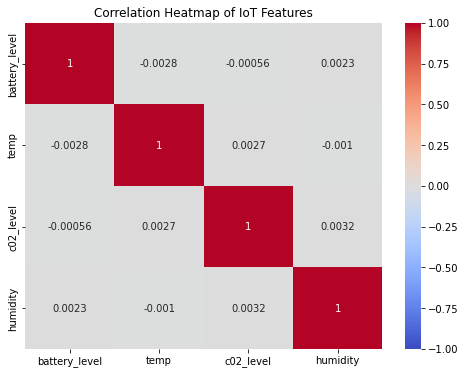

In [ ]:
import seaborn as sns

# Select numerical columns and convert to Pandas
numerical_data = df.select("battery_level", "temp", "c02_level", "humidity").toPandas()

# Calculate correlations
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of IoT Features")
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import OneVsRest
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

# Prepare data for Isolation Forest or other anomaly detection
assembler = VectorAssembler(inputCols=["battery_level", "c02_level", "temp"], outputCol="features")
device_features = assembler.transform(df).select("features")

# Set up an Isolation Forest or use KMeans as a proxy for anomaly detection
isolation_forest = KMeans(k=2, seed=1, featuresCol="features")
model = isolation_forest.fit(device_features)

# Use the model to predict clusters
predictions = model.transform(device_features)
predictions.show()

+-----------------+----------+
|         features|prediction|
+-----------------+----------+
| [8.0,868.0,34.0]|         1|
|[7.0,1473.0,11.0]|         0|
|[2.0,1556.0,19.0]|         0|
|[6.0,1080.0,28.0]|         1|
| [4.0,931.0,25.0]|         1|
|[3.0,1210.0,27.0]|         0|
|[3.0,1129.0,18.0]|         1|
|[0.0,1536.0,27.0]|         0|
| [3.0,807.0,13.0]|         1|
|[7.0,1470.0,26.0]|         0|
|[3.0,1544.0,16.0]|         0|
|[0.0,1260.0,12.0]|         0|
|[6.0,1007.0,13.0]|         1|
|[1.0,1346.0,16.0]|         0|
|[9.0,1259.0,13.0]|         0|
|[4.0,1425.0,15.0]|         0|
|[0.0,1466.0,31.0]|         0|
|[4.0,1096.0,31.0]|         1|
|[9.0,1531.0,29.0]|         0|
|[7.0,1155.0,10.0]|         1|
+-----------------+----------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import when, col, count

# Step 1: Create a new DataFrame with a brand column
device_dist = df.withColumn(
    "brand",
    when(col("device_name").like("device-mac%"), "Mac")
    .when(col("device_name").like("device-samsung%"), "Samsung")
    .when(col("device_name").like("device-apple%"), "Apple")
    .when(col("device_name").like("device-dell%"), "Dell")
    .otherwise("Other")
)

# Step 2: Group by country and brand, then count devices
device_dist = device_dist.groupBy("cn", "brand").agg(count("device_name").alias("device_count"))

# Show the new DataFrame with device counts by country and brand
device_dist.show()

+--------------------+-----+------------+
|                  cn|brand|device_count|
+--------------------+-----+------------+
|               Chile|Other|         314|
|  Dominican Republic|Other|          16|
|            Portugal|Other|         364|
|             Ecuador|  Mac|          32|
|              Zambia|Other|           6|
|Saint Vincent and...|Other|           9|
|            Honduras|  Mac|          14|
|             Hungary|Other|         647|
|              Taiwan|  Mac|         376|
|            Colombia|Other|         353|
|           Guatemala|  Mac|          18|
|        Saudi Arabia|  Mac|          27|
|Hashemite Kingdom...|Other|          41|
|            Thailand|  Mac|         163|
|            Pakistan|  Mac|          35|
|               Syria|Other|           4|
|           Venezuela|  Mac|          42|
|             Bermuda|Other|          44|
|              Kuwait|Other|         110|
|             Armenia|Other|          26|
+--------------------+-----+------